In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from utils import rnmse
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
import pandas as pd
import seaborn as sns
import matplotlib
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('hot', n_colors=7)
plt.rc('text', usetex=True)      

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [2]:
x = torch.cat([torch.load("../dataset/x_train.pt"), torch.load("../dataset/x_train_2.pt")])
y = torch.cat([torch.load("../dataset/y_train.pt"), torch.load("../dataset/y_train_2.pt")])
c = torch.cat([torch.load("../dataset/c_train.pt"), torch.load("../dataset/c_train_2.pt")])

x_test = torch.load("../dataset/x_test.pt")
y_test = torch.load("../dataset/y_test.pt")
c_test = torch.load("../dataset/c_test.pt")

In [3]:
x_np, y_np, c_np = x.numpy(), y.numpy(), c.numpy()
x_np_reshaped, y_np_reshaped, c_np_reshaped = x_np.reshape((x_np.shape[0], -1)), y_np.reshape((y_np.shape[0], -1)), c_np.reshape((c_np.shape[0], -1))
x_test_np, y_test_np, c_test_np = x_test.numpy(), y_test.numpy(), c_test.numpy()
x_test_np_reshaped, y_test_np_reshaped, c_test_np_reshaped = x_test_np.reshape((x_test_np.shape[0], -1)), y_test_np.reshape((y_test_np.shape[0], -1)), c_test_np.reshape((c_test_np.shape[0], -1))

In [4]:
def scorer_rnmse(estimator, x, y):
    return rnmse(estimator.predict(x), y)

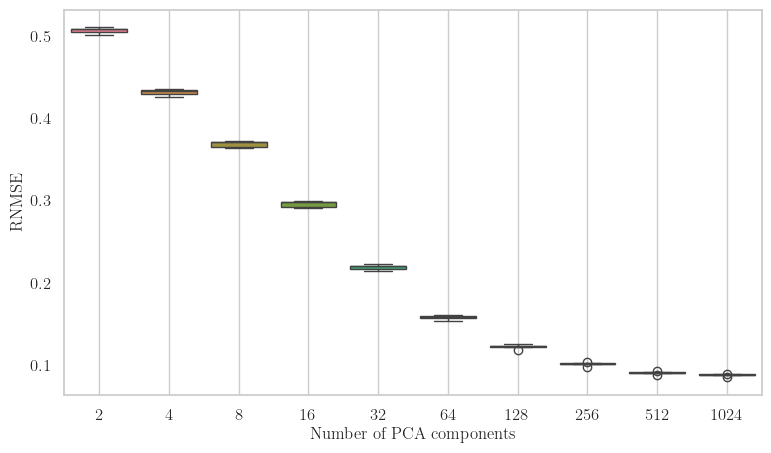

In [6]:
PCA_eval = False
n_points = y_np_reshaped.shape[0]
if PCA_eval:
    pca_errors = {i: [] for i in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]}
    for n_components in tqdm(pca_errors):
        pipe_lm = TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components)),
                ("lm", LinearRegression(n_jobs=-1))
            ]),
            transformer=PCA(n_components=n_components),
            check_inverse=False
        )
        pca_errors[n_components] = cross_val_score(
            pipe_lm,
            x_np_reshaped[:n_points], y_np_reshaped[:n_points],
            cv=5,
            scoring=scorer_rnmse
        )
    pd.DataFrame(pca_errors).to_csv('pca_analysis_results/results.csv')
d = pd.read_csv('pca_analysis_results/results.csv')
plt.figure(figsize=(9, 5))
sns.boxplot(d)
plt.grid()
plt.xlabel("Number of PCA components")
plt.ylabel("RNMSE")
plt.savefig('pca_error.jpg', dpi=150)